06/13/2023 02:35:49PM - __main__DEBUG: python: 3.8.10
06/13/2023 02:35:49PM - __main__DEBUG: opencv: 4.2.0


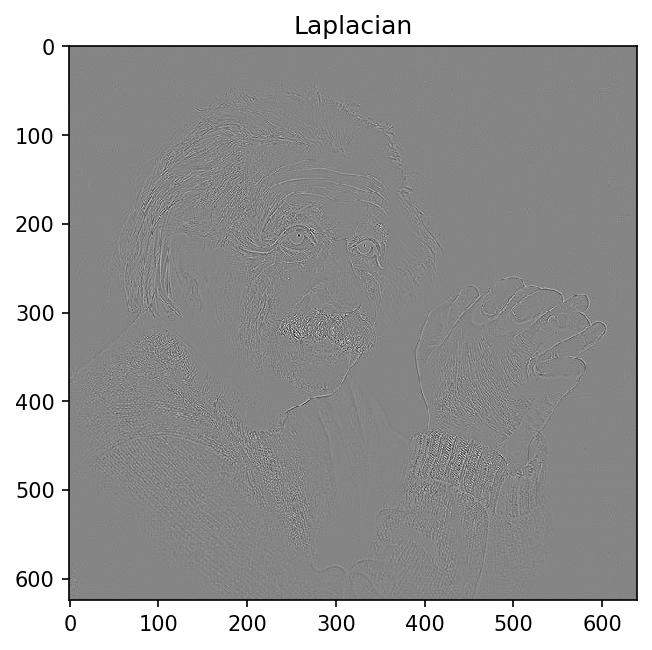

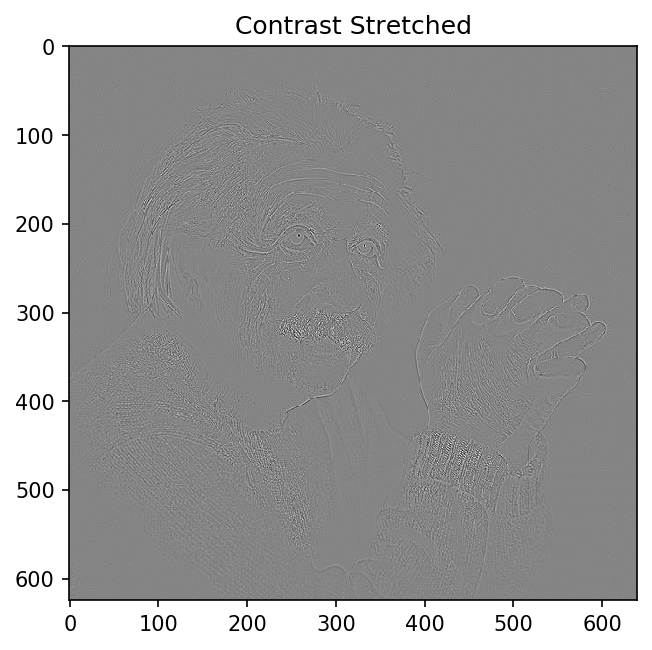

In [1]:
import pathlib
import os
import sys
import subprocess
import logging
import platform

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl

global global_logger

def fatal_error(msg):
  global_logger.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  global_logger.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    global_logger.debug(msg)

def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def main():
  trace(f"opencv: {cv.__version__}")
  mpl.rcParams['figure.dpi']= 150

  images_dir="COMP9517_23T2_Lab1_Images"

  einstein_img = cv.imread(f"{images_dir}/Einstein.png")

  laplacian_img = compute_laplacian(einstein_img)
  plt.imshow(laplacian_img)
  plt.title('Laplacian')
  plt.show()

  contrast_stretched_laplacian_img = contrast_stretch_grayscale(laplacian_img)
  plt.imshow(contrast_stretched_laplacian_img)
  plt.title('Contrast Stretched')
  plt.show()

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()


if __name__ == "__main__":
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
  # if sys.gettrace() is None:
  #   os.environ["PYTHONBREAKPOINT"] = "0"

  # directory_of_running_script = pathlib.Path(__file__).parent.resolve()
  # os.chdir(directory_of_running_script)
  global_logger = logging.getLogger(__name__)
  global_logger.setLevel(logging.DEBUG)
  global_logger_handler = logging.StreamHandler()
  global_logger_handler.setLevel(logging.DEBUG)
  global_logger_formatter = logging.Formatter('%(asctime)s - %(name)s%(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S%p')
  global_logger_handler.setFormatter(global_logger_formatter)
  global_logger.addHandler(global_logger_handler)

  trace(f"python: {platform.python_version()}")

  main()
